<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset-CNN/blob/main/cnn_kodu2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [94]:
# Kaggle'dan veri setini indirin
path = kagglehub.dataset_download("phhasian0710/dreamer")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1


In [95]:
# Custom Veri Artırma: Flip Fonksiyonu
import random
class CustomRandomFlip:
    def __init__(self, axis):
        self.axis = axis

    def __call__(self, x):
        if random.random() > 0.5:
            x = torch.flip(x, dims=(self.axis,))
        return x

# DREAMER Veri Setini Yükleme
dataset = DREAMERDataset(
    io_path='./dreamer_cnn_data',
    mat_path='DREAMER.mat',
    offline_transform=transforms.Compose([
        transforms.BaselineRemoval(),
        transforms.MeanStdNormalize(),
        transforms.To2d(),
        transforms.RandomNoise(std=0.01),
        CustomRandomFlip(axis=2)
    ]),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose([
        transforms.Select('valence'),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-18 22:42:26] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./dreamer_cnn_data.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from ./dreamer_cnn_data.


In [96]:
# Veri setini eğitim ve test olarak ayırın
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [97]:
# Veri Yükleyicileri
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [98]:
class EEG_CNN_Model(nn.Module):
    def __init__(self):
        super(EEG_CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.5)

        # Fully connected giriş boyutunu hesapla
        self.fc1 = nn.Linear(128 * 1 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [99]:
# Modeli, Kayıp Fonksiyonu ve Optimizasyon Tanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Eğitim Fonksiyonu
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Test Fonksiyonu
def test_model():
    model.eval()
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_labels, all_preds

In [100]:
# Model Eğitim Döngüsü
epochs, patience = 10, 3
best_loss, counter = float('inf'), 0
train_losses, test_losses, test_accs = [], [], []

for epoch in range(epochs):
    train_loss = train_one_epoch()
    test_loss, test_acc, _, _ = test_model()
    scheduler.step()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    if test_loss < best_loss:
        best_loss, counter = test_loss, 0
        print("En iyi model kaydedildi!")
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping tetiklendi!")
        break

Epoch 1: Train Loss: 0.6305, Test Loss: 0.5793, Test Acc: 0.6861
En iyi model kaydedildi!
Epoch 2: Train Loss: 0.5640, Test Loss: 0.5360, Test Acc: 0.7238
En iyi model kaydedildi!
Epoch 3: Train Loss: 0.5183, Test Loss: 0.5005, Test Acc: 0.7221
En iyi model kaydedildi!
Epoch 4: Train Loss: 0.4802, Test Loss: 0.4727, Test Acc: 0.7512
En iyi model kaydedildi!
Epoch 5: Train Loss: 0.4438, Test Loss: 0.4364, Test Acc: 0.7827
En iyi model kaydedildi!
Epoch 6: Train Loss: 0.4092, Test Loss: 0.4116, Test Acc: 0.7960
En iyi model kaydedildi!
Epoch 7: Train Loss: 0.3755, Test Loss: 0.3960, Test Acc: 0.8105
En iyi model kaydedildi!
Epoch 8: Train Loss: 0.3450, Test Loss: 0.3863, Test Acc: 0.8180
En iyi model kaydedildi!
Epoch 9: Train Loss: 0.3212, Test Loss: 0.3816, Test Acc: 0.8220
En iyi model kaydedildi!
Epoch 10: Train Loss: 0.3053, Test Loss: 0.3817, Test Acc: 0.8238


Final Test Accuracy: 0.8238
Confusion Matrix:
 [[5032 1722]
 [1300 9095]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      6754
           1       0.84      0.87      0.86     10395

    accuracy                           0.82     17149
   macro avg       0.82      0.81      0.81     17149
weighted avg       0.82      0.82      0.82     17149



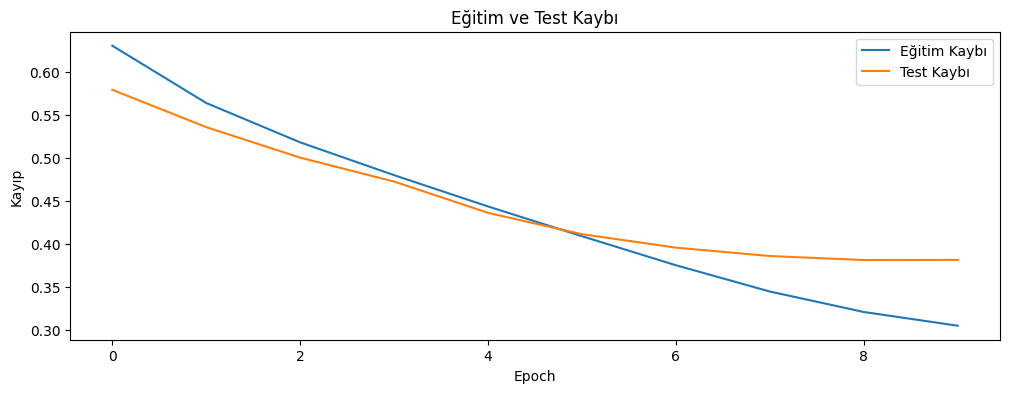

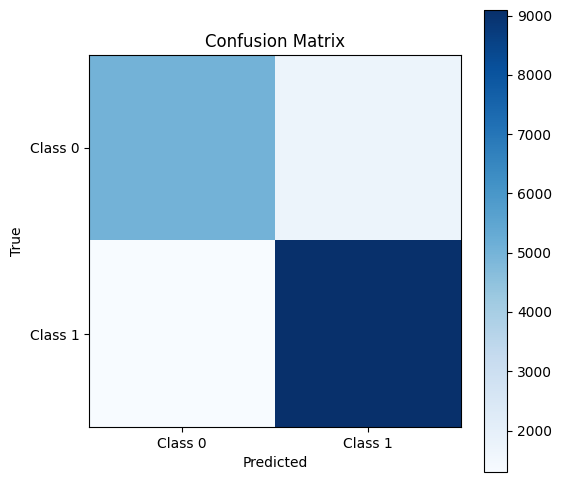

In [101]:
# Sonuçları tekrar test edip raporla
test_loss, test_acc, all_labels, all_preds = test_model()
print(f"Final Test Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))

def plot_results(labels, preds, train_losses, test_losses):
    # Basitleştirilmiş grafik fonksiyonu
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(labels, preds)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(all_labels, all_preds, train_losses, test_losses)

In [102]:
print(f"Best Loss: {best_loss:.4f}, Current Test Loss: {test_loss:.4f}")

Best Loss: 0.3816, Current Test Loss: 0.3817


In [103]:
print(f"Toplam veri sayısı: {len(train_loader.dataset)}")
print(f"Toplam batch sayısı (train): {len(train_loader)}")

Toplam veri sayısı: 68595
Toplam batch sayısı (train): 2144
